In [32]:
import os
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import tensorflow as tf
from Bio import SeqIO
from tqdm.notebook import tqdm

In [33]:
project_dir = "C:\\Users\\tilenkopac\\Projects\\genome-embedding"
data_dir = os.path.join(project_dir, "data", "deepmicrobes_mock_communities")
models_dir = os.path.join(project_dir, "models")
autoencoder_name = "661k_conv_small_elu_loc_pres_ld10_ws100_take_2"
sampler_name = "no-sampler"

In [35]:
# models
autoencoder = tf.keras.models.load_model(os.path.join(models_dir, "autoencoders", autoencoder_name))
encoder = autoencoder.encoder
classifier = tf.keras.models.load_model(os.path.join(models_dir, "classifiers", autoencoder_name, sampler_name,
                                                     "mag-reads-genus-classifier-4-layers-32-units-inverse-class-weights"))
classifier2 = tf.keras.models.load_model(os.path.join(models_dir, "classifiers", autoencoder_name, sampler_name,
                                                      "mag-reads-genus-classifier-4-layers-32-units"))
print(f"Classifier output size: {classifier.layers[0].layers[-1].output.shape[-1]}")

# data
mag_reads_data_dir = os.path.join(project_dir, "data", "deepmicrobes_mag_reads")
with open(os.path.join(mag_reads_data_dir, "taxa_index.pkl"), "rb") as file:
    taxa_index = pickle.load(file)

Classifier output size: 46


In [36]:
organism_taxa = {}
with open(os.path.join(data_dir, "community_supplementary_data.csv"), "rt") as file:
    file.readline()
    file.readline()
    for line in file:
        fields = line.split(";")
        org_id = fields[0]
        org_taxon = taxa_index["genus"].get(fields[2], -1)
        organism_taxa[org_id] = org_taxon

In [37]:
nuc_onehot_enc = {
    "A": [1.0, 0.0, 0.0, 0.0],
    "G": [0.0, 1.0, 0.0, 0.0],
    "C": [0.0, 0.0, 1.0, 0.0],
    "T": [0.0, 0.0, 0.0, 1.0],
    "N": [0.0, 0.0, 0.0, 0.0]}


def preprocess_seq(seq):
    # cut sequence to correct length
    seq = seq[:100]

    # one-hot encode nucleotides
    encoded = [nuc_onehot_enc[nuc] for nuc in seq]

    return encoded

In [38]:
n_reads = 10000000
reads_preprocessed = []
labels = []
unknown_taxa_count = 0
with open(os.path.join(data_dir, "mock_metagenome_01.1.fq"), "rt") as file:
    reads = SeqIO.parse(file, "fastq")
    for i, read in tqdm(enumerate(reads), total=n_reads):
        if len(read) >= 100:
            org_taxon = organism_taxa[read.id.split(".")[0]]
            if org_taxon != -1:
                # organism's taxon is in the set of taxa known by the classifier
                reads_preprocessed.append(preprocess_seq(read.seq))
                labels.append(org_taxon)
            else:
                # organism's taxon is not known by the classifier
                unknown_taxa_count += 1

        # if i == 100000:
        #     break

  0%|          | 0/10000000 [00:00<?, ?it/s]

In [39]:
unknown_taxa_count / n_reads

0.1404781

In [40]:
predictions = []
for i in tqdm(range(0, len(reads_preprocessed), 4096)):
    embeddings = encoder(tf.constant(reads_preprocessed[i:i + 4096]))
    predictions.extend(tf.argmax(classifier(embeddings), axis=-1).numpy())

predictions2 = []
for i in tqdm(range(0, len(reads_preprocessed), 4096)):
    embeddings = encoder(tf.constant(reads_preprocessed[i:i + 4096]))
    predictions2.extend(tf.argmax(classifier2(embeddings), axis=-1).numpy())

  0%|          | 0/2035 [00:00<?, ?it/s]

  0%|          | 0/2035 [00:00<?, ?it/s]

In [41]:
conf_mat = tf.math.confusion_matrix(labels[:len(predictions)], predictions).numpy()
conf_mat_norm_rows = sklearn.preprocessing.normalize(conf_mat, axis=1, norm="l1")

conf_mat2 = tf.math.confusion_matrix(labels[:len(predictions2)], predictions2).numpy()
conf_mat_norm_rows2 = sklearn.preprocessing.normalize(conf_mat2, axis=1, norm="l1")

Precision: 0.000894430555878871


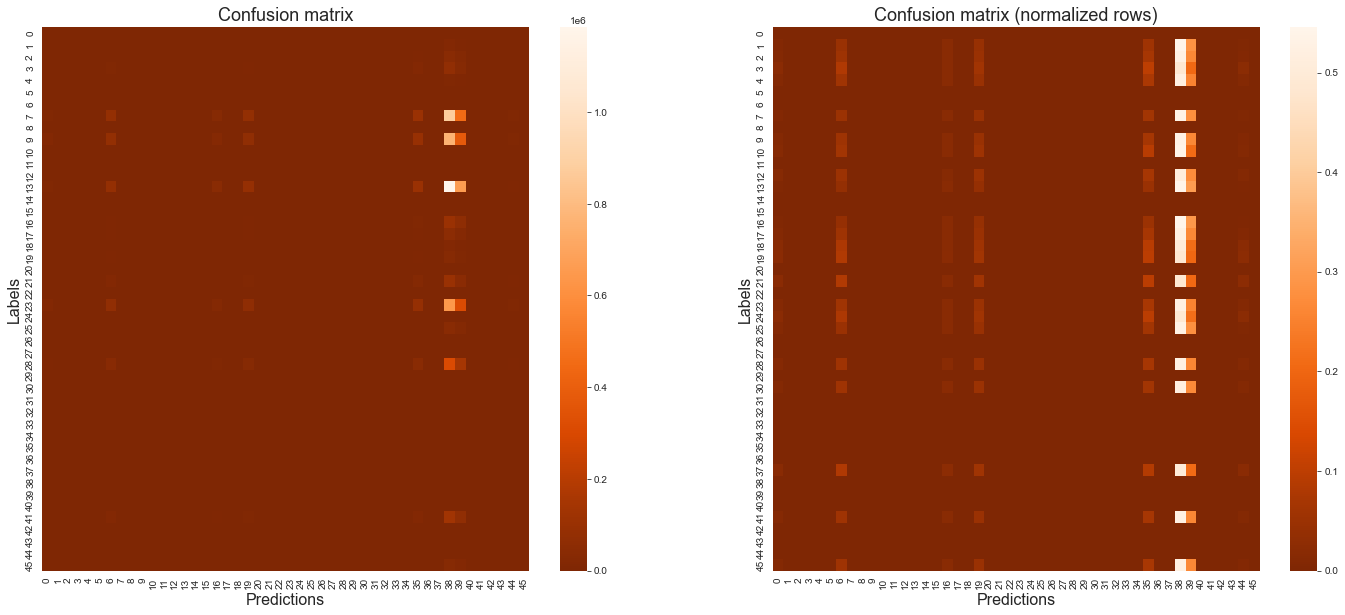

In [42]:
print(f"Precision: {sum(conf_mat.diagonal()) / sum(conf_mat.flatten())}")

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
sns.heatmap(conf_mat, ax=ax1, cmap='Oranges_r')
ax1.set_xlabel("Predictions", fontsize=16)
ax1.set_ylabel("Labels", fontsize=16)
ax1.set_title("Confusion matrix", fontsize=18)

sns.heatmap(conf_mat_norm_rows, ax=ax2, cmap='Oranges_r')
ax2.set_xlabel("Predictions", fontsize=16)
ax2.set_ylabel("Labels", fontsize=16)
ax2.set_title("Confusion matrix (normalized rows)", fontsize=18);

Precision: 0.034460895001724307


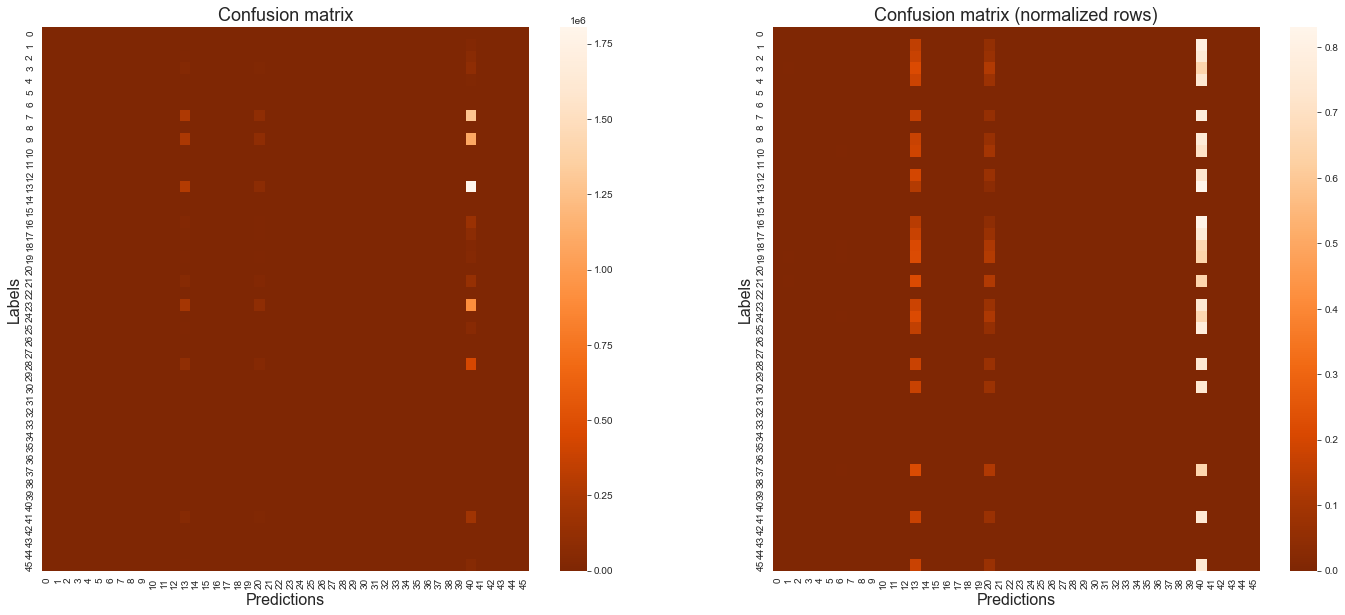

In [43]:
print(f"Precision: {sum(conf_mat2.diagonal()) / sum(conf_mat2.flatten())}")

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
sns.heatmap(conf_mat2, ax=ax1, cmap='Oranges_r')
ax1.set_xlabel("Predictions", fontsize=16)
ax1.set_ylabel("Labels", fontsize=16)
ax1.set_title("Confusion matrix", fontsize=18)

sns.heatmap(conf_mat_norm_rows2, ax=ax2, cmap='Oranges_r')
ax2.set_xlabel("Predictions", fontsize=16)
ax2.set_ylabel("Labels", fontsize=16)
ax2.set_title("Confusion matrix (normalized rows)", fontsize=18);